# Comparing instance segmentation of trees and watershed-based instance segmentation of semantically segmented trees

## To-dos
- **Perform grid search to determine best hyperparameters (batch size, epochs, learning rate)**
    - Don't forget to also incorporate KFolds CV!
- **Improve quality of watershed labels**
    - Review the labels and remove non-tree labels
- **Generate boundaries on label data**
    - Only applicable if using the U-Net approach (I think?)
    - Consider using a positive boundary (dilate) and a negative (erode) and compare
- **Incorporate KFolds (10 folds) cross-validation into model training**
    - I.e. Leave a test set alone and then use KFolds on the training set to derive train/val subsets)
- **Consider the Mask RCNN approach: https://github.com/matterport/Mask_RCNN**
   
---

## Instance segmentation

---

### Imports and function defs

In [12]:
import glob

import numpy as np
import tifffile as tiff
from patchify import patchify
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img


def patch_train_label(raster, labels, img_size, channels=False, merge_channel=False):
    samp_rast = tiff.imread(raster[0])
    img_base_size = samp_rast.shape[0]
    n = len(raster)
    m = (img_base_size // img_size) ** 2

    if not channels:
        channels = samp_rast.shape[-1]

    if merge_channel:
        channels += tiff.imread(merge_channel[0]).shape[-1]

    data_train = np.zeros((n * m, img_size, img_size, channels))
    data_label = np.zeros((n * m, img_size, img_size))

    for k in range(n):
        if merge_channel:
            r = np.concatenate(
                (tiff.imread(raster[k]), tiff.imread(merge_channel[k])), axis=-1
            )
        else:
            r = tiff.imread(raster[k])[..., :channels]

        # Only read in the specified number of channels from input raster
        patches_train = patchify(
            r,
            (img_size, img_size, channels),
            step=img_size,
        )
        patches_label = patchify(
            tiff.imread(labels[k]), (img_size, img_size), step=img_size
        )
        data_train[k * m : (k + 1) * m, :, :, :] = patches_train.reshape(
            -1, img_size, img_size, channels
        )
        data_label[k * m : (k + 1) * m, :, :] = patches_label.reshape(
            -1, img_size, img_size
        )

    data_label = (data_label > 0).astype("int")
    data_label = np.expand_dims(data_label, axis=-1)
    data_train = data_train.astype("float") / 255

    print(
        f"\nData sizes:\ndata_train: {data_train.shape}\ndata_label: {data_label.shape}\n"
    )

    return data_train, data_label

2022-09-26 11:13:56.057225: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-26 11:13:56.203370: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-26 11:13:56.739461: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/miniconda/envs/lusk_dap05/lib/
2022-09-26 11:13:56.739525: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin

### Load, patchify, and split the data

In [11]:
# Patchify hand-labeled data PLUS NIR data
data_dir = "../data/"
hand_rgb_dir = f"{data_dir}train_rgb/"
hand_nir_dir = f"{data_dir}train_nir/"
hand_label_dir = f"{data_dir}label/"

patch_rgb = glob.glob(f"{hand_rgb_dir}*.tif")
patch_nir = glob.glob(f"{hand_nir_dir}*.tif")
patch_label = glob.glob(f"{hand_label_dir}*.tif")
patch_rgb.sort()
patch_label.sort()

print("Patchifying RGB + NIR data...")
data_train, data_label = patch_train_label(
    patch_rgb, patch_label, 128, merge_channel=patch_nir
)

# Patchify watershed data (pre-patchified)
patched_watershed_rgbi_dir = f"{data_dir}watershed/512/rgbi/"
patched_watershed_label_dir = f"{data_dir}watershed/512/labels/"

watershed_rgbi = glob.glob(f"{patched_watershed_rgbi_dir}*.tif")
watershed_labels = glob.glob(f"{patched_watershed_label_dir}*.tif")
watershed_rgbi.sort()
watershed_labels.sort()

print("Patchifying watershed data...")
data_train_ws, data_label_ws = patch_train_label(watershed_rgbi, watershed_labels, 128)

data_train = np.vstack((data_train, data_train_ws))
data_label = np.vstack((data_label, data_label_ws))

print(
    f"\nSizes after adding watershed data:\n\
data_train: {data_train.shape}\n\
data_label: {data_label.shape}\n"
)

x_train, x_test, y_train, y_test = train_test_split(
    data_train, data_label, test_size=0.1, random_state=157
)

print(
    f"\nSizes after splitting data:\n\
x_train: {x_train.shape}\n\
y_train: {y_train.shape}\n\
x_test: {x_test.shape}\n\
y_test: {y_test.shape}"
)

Patchifying RGB + NIR data...

Data sizes:
data_train: (576, 128, 128, 4)
data_label: (576, 128, 128, 1)

Patchifying watershed data...

Data sizes:
data_train: (5184, 128, 128, 4)
data_label: (5184, 128, 128, 1)


Sizes after adding watershed data:
data_train: (5760, 128, 128, 4)
data_label: (5760, 128, 128, 1)


Sizes after splitting data:
x_train: (5184, 128, 128, 4)
y_train: (5184, 128, 128, 1)
x_test: (576, 128, 128, 4)
y_test: (576, 128, 128, 1)


In [ ]:
class TreeDataset()

## Messing around

In [15]:
im_fn = glob.glob("../data/watershed/512/labels/*.tif")
im = tiff.imread(im_fn[0])

In [ ]:
import sys
numpy.set_printoptions(threshold=sys.maxsize)

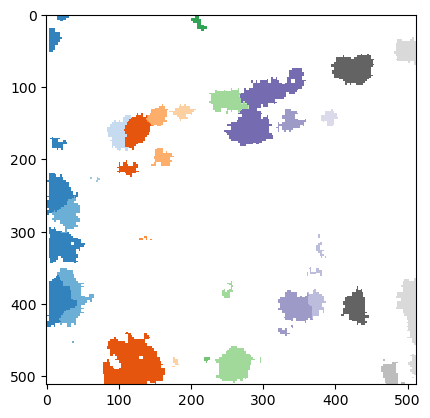

In [27]:
import matplotlib.pyplot as plt
im.astype("float")
im[im == 0] = np.nan
plt.imshow(im, cmap=plt.cm.tab20c)

## Semantic watershed segmentation